# Load packages

In [33]:
import pandas as pd
from bertopic import BERTopic
import joblib
import numpy as np

from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import plotly.express as px
import nbformat

# Load BERTopic Model

In [5]:
topic_model = BERTopic.load("topic_model")

full_data = joblib.load("bertopic_results_data.joblib")
topics = full_data["topics"]
probabilities = full_data["probabilities"]
topic_info = full_data["topic_info"]
docs_clean = full_data["docs"]

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
TOPICS = topic_model.get_document_info(docs_clean)
print(TOPICS)

In [ ]:
fig_01 = topic_model.visualize_barchart(top_n_topics = 20)
fig_01.show ()

In [ ]:
topic_model.visualize_heatmap()

# Here starts Fitness & Complexity algorithm

## Create binary matrix

In [7]:
# Load csv document
df_docs = pd.read_csv("Data_20250506.csv", sep=";")

topic_index = topic_model.get_document_info(docs_clean)
#print (topic_index)                                        # Get topic information

df_topics = pd.DataFrame ({
    "country" : df_docs ["COUNTRY"],
    "topic" : topic_index ["Topic"]
})                                                          # Create dataframe

matrix_brut = pd.get_dummies (df_topics ["topic"])     # Create binnary matrix (Flase & True)

matrix_brut.columns = [f"topic_{i}" for i in matrix_brut.columns]
matrix_brut.index = df_topics ["country"]

print (matrix_brut.head(20))


                topic_0  topic_1  topic_2  topic_3  topic_4  topic_5  topic_6  \
country                                                                         
JAPAN             False    False    False    False    False     True    False   
IRELAND           False    False    False    False    False    False     True   
GREECE            False    False    False     True    False    False    False   
BELGIUM           False    False     True    False    False    False    False   
SPAIN             False    False    False    False    False    False    False   
SWEDEN            False    False    False    False     True    False    False   
GERMANY            True    False    False    False    False    False    False   
NETHERLANDS       False    False    False    False    False    False    False   
GERMANY            True    False    False    False    False    False    False   
UNITED KINGDOM    False    False    False    False    False    False    False   
CANADA            False    F

In [8]:
matrix_country_topic = (matrix_brut.groupby("country").sum() > 0).astype(int)
print (type(matrix_country_topic))
print (matrix_country_topic.head(20))
matrix_country_topic.to_clipboard()


<class 'pandas.core.frame.DataFrame'>
                        topic_0  topic_1  topic_2  topic_3  topic_4  topic_5  \
country                                                                        
ALBANIA                       0        0        0        1        0        0   
ALGERIA                       0        0        1        0        0        0   
ARGENTINA                     0        1        0        1        0        0   
AUSTRALIA                     1        1        1        1        1        1   
AUSTRIA                       1        1        1        1        1        1   
BANGLADESH                    0        0        0        1        1        0   
BELARUS                       0        1        0        0        0        1   
BELGIUM                       1        1        1        1        1        1   
BOSNIA AND HERZEGOVINA        0        0        0        0        0        0   
BOSNIA \& HERCEG              0        0        0        0        0        0   
BR

In [9]:
countries = matrix_country_topic.index          # Country labels
topics = matrix_country_topic.columns           # Topic labels

Mct = matrix_country_topic.to_numpy()           # Matrix for analyses
R,C=Mct.shape
print (Mct)


[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## First steps

### Diversity

In [10]:
diversity = matrix_country_topic.sum(axis = 1)
print(diversity)
ubiquity = matrix_country_topic.sum(axis=0)
print(ubiquity)

country
ALBANIA           1
ALGERIA           7
ARGENTINA         4
AUSTRALIA        39
AUSTRIA          24
                 ..
UNITED STATES    44
URUGUAY           2
UZBEKISTAN        2
VIET NAM          7
ZAMBIA            1
Length: 107, dtype: int64
topic_0     55
topic_1     55
topic_2     50
topic_3     48
topic_4     51
topic_5     42
topic_6     49
topic_7     52
topic_8     32
topic_9     27
topic_10    48
topic_11    26
topic_12    50
topic_13    45
topic_14    36
topic_15    32
topic_16    38
topic_17    36
topic_18    29
topic_19    34
topic_20    30
topic_21    32
topic_22    25
topic_23    32
topic_24    29
topic_25    17
topic_26    28
topic_27    35
topic_28    27
topic_29    31
topic_30    24
topic_31    30
topic_32    30
topic_33    32
topic_34    31
topic_35    24
topic_36    28
topic_37    25
topic_38    20
topic_39    21
topic_40    21
topic_41    22
topic_42    22
topic_43    17
topic_44    19
topic_45    14
topic_46    13
topic_47     6
topic_48     5
topic_49   

### Fitness

In [11]:
def fitness_complexity(M, max_iter=1000, tol=1e-8):
    """
    Computes the fitness of countries and the complexity of products using the Fitness-Complexity algorithm.
    
    Parameters:
        M (numpy.ndarray): Binary matrix of size (n_countries, n_products) where M[c, p] = 1 if country c has
                           a competitive advantage in product p, 0 otherwise.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.
        
    Returns:
        fitness (numpy.ndarray): Vector of fitness values for each country.
        complexity (numpy.ndarray): Vector of complexity values for each product.
    """
    n_c, n_p = M.shape
    fitness = np.ones(n_c)
    complexity = np.ones(n_p)
    
    for iteration in range(max_iter):
        fitness_old = fitness.copy()
        complexity_old = complexity.copy()
        
        # Update fitness: sum of the complexities of the products a country exports
        fitness = M.dot(complexity_old)
        fitness[fitness == 0] = 1e-12  # Prevent division by zero
        
        # Update complexity: inverse of the weighted sum of the inverse fitness of countries exporting the product
        denom = (M.T / fitness_old).sum(axis=1)
        denom[denom == 0] = 1e-12  # Prevent division by zero
        complexity = 1 / denom
        
        # Normalize to maintain numerical stability
        fitness = fitness / np.mean(fitness)
        complexity = complexity / np.mean(complexity)
        
        # Check for convergence
        if (np.abs(fitness - fitness_old).sum() < tol) and (np.abs(complexity - complexity_old).sum() < tol):
            print(f"Convergence reached in {iteration+1} iterations.")
            break
    else:
        print("Convergence not reached within the maximum number of iterations.")
    
    return fitness, complexity

In [12]:
# Execute the Fitness-Complexity algorithm
fitness_values, complexity_values = fitness_complexity(Mct)

Convergence reached in 718 iterations.


In [13]:
# Create a DataFrame with the fitness values
df_fitness = pd.DataFrame({
    'Country': matrix_country_topic.index,
    'Fitness': fitness_values
})

### Complexity

In [14]:
# Create a DataFrame with the complexity values
df_complex = pd.DataFrame({
    'Topic': matrix_country_topic.columns,
    'Complexity': complexity_values
})

# Arrange the topics by complexity
COMPLEX = df_complex.sort_values(by='Complexity', ascending=False)

print(COMPLEX)

       Topic  Complexity
47  topic_47    9.494155
48  topic_48    8.320681
49  topic_49    8.235660
46  topic_46    2.448764
25  topic_25    1.722833
40  topic_40    1.470270
43  topic_43    1.336917
45  topic_45    1.296850
30  topic_30    1.130104
38  topic_38    0.927700
41  topic_41    0.823676
22  topic_22    0.819777
42  topic_42    0.728014
26  topic_26    0.701203
35  topic_35    0.624059
23  topic_23    0.619370
44  topic_44    0.599748
39  topic_39    0.567098
37  topic_37    0.556219
36  topic_36    0.551926
32  topic_32    0.527394
11  topic_11    0.518060
20  topic_20    0.516882
9    topic_9    0.488524
28  topic_28    0.475672
14  topic_14    0.458188
16  topic_16    0.443688
21  topic_21    0.405770
24  topic_24    0.392979
29  topic_29    0.388317
18  topic_18    0.324707
19  topic_19    0.302877
5    topic_5    0.280545
8    topic_8    0.206383
15  topic_15    0.196188
17  topic_17    0.188222
10  topic_10    0.165848
27  topic_27    0.137843
7    topic_7    0.110543


### Proximity

In [15]:
def topic_proximity(Mct):
   
    # Co-occurrence matrix: number of countries researching both topics
    C = Mct.T.dot(Mct)
    
    n_topics = Mct.shape[1]
    proximity = np.zeros((n_topics, n_topics))
    
    # Calculate proximity between topics
    for i in range(n_topics):
        for j in range(n_topics):
            if ubiquity[i] > 0 and ubiquity[j] > 0:
                proximity[i, j] = min(C[i, j] / ubiquity[i], C[i, j] / ubiquity[j])
            else:
                proximity[i, j] = 0
    return proximity

def adjacent_topics(proximity, threshold=0.5):

    n_topics = proximity.shape[0]
    adjacents = {}
    for i in range(n_topics):
        # Obtain topics with proximity above the threshold
        neighbors = np.where(proximity[i] >= threshold)[0]
        # If the topic is its own neighbor, remove it
        neighbors = neighbors[neighbors != i]
        adjacents[i] = neighbors.tolist()
    return adjacents



In [19]:
# Calculate the proximity matrix
proximity_matrix = topic_proximity(Mct)

# Identify adjacent topics
adjacent_dict = adjacent_topics(proximity_matrix, threshold=0.5)

# Convert the dictionary to a DataFrame
df_adjacents = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in adjacent_dict.items()]))
print(proximity_matrix)


[[1.         0.76363636 0.69090909 ... 0.10909091 0.07272727 0.07272727]
 [0.76363636 1.         0.67272727 ... 0.10909091 0.05454545 0.07272727]
 [0.69090909 0.67272727 1.         ... 0.12       0.08       0.08      ]
 ...
 [0.10909091 0.10909091 0.12       ... 1.         0.16666667 0.33333333]
 [0.07272727 0.05454545 0.08       ... 0.16666667 1.         0.        ]
 [0.07272727 0.07272727 0.08       ... 0.33333333 0.         1.        ]]


## Graphics (test version)

In [20]:
def create_product_space_graph(proximity, threshold=0.5, product_labels=None):

    n_topics = proximity.shape[0]
    G = nx.Graph()
    
    # Add nodes: use topic labels if available, otherwise use indices
    for i in range(n_topics):
        label = product_labels[i] if product_labels is not None else str(i)
        G.add_node(i, label=label)
    
    # Agregar aristas: solo se consideran pares de productos con proximidad mayor o igual al umbral
    for i in range(n_topics):
        for j in range(i+1, n_topics):  # Recorrer solo una vez cada par
            if proximity[i, j] >= threshold:
                # Se puede usar la proximidad como peso de la arista
                G.add_edge(i, j, weight=proximity[i, j])
    
    return G


In [21]:
# Example
G = create_product_space_graph(proximity_matrix, threshold=0.5, product_labels=topics)


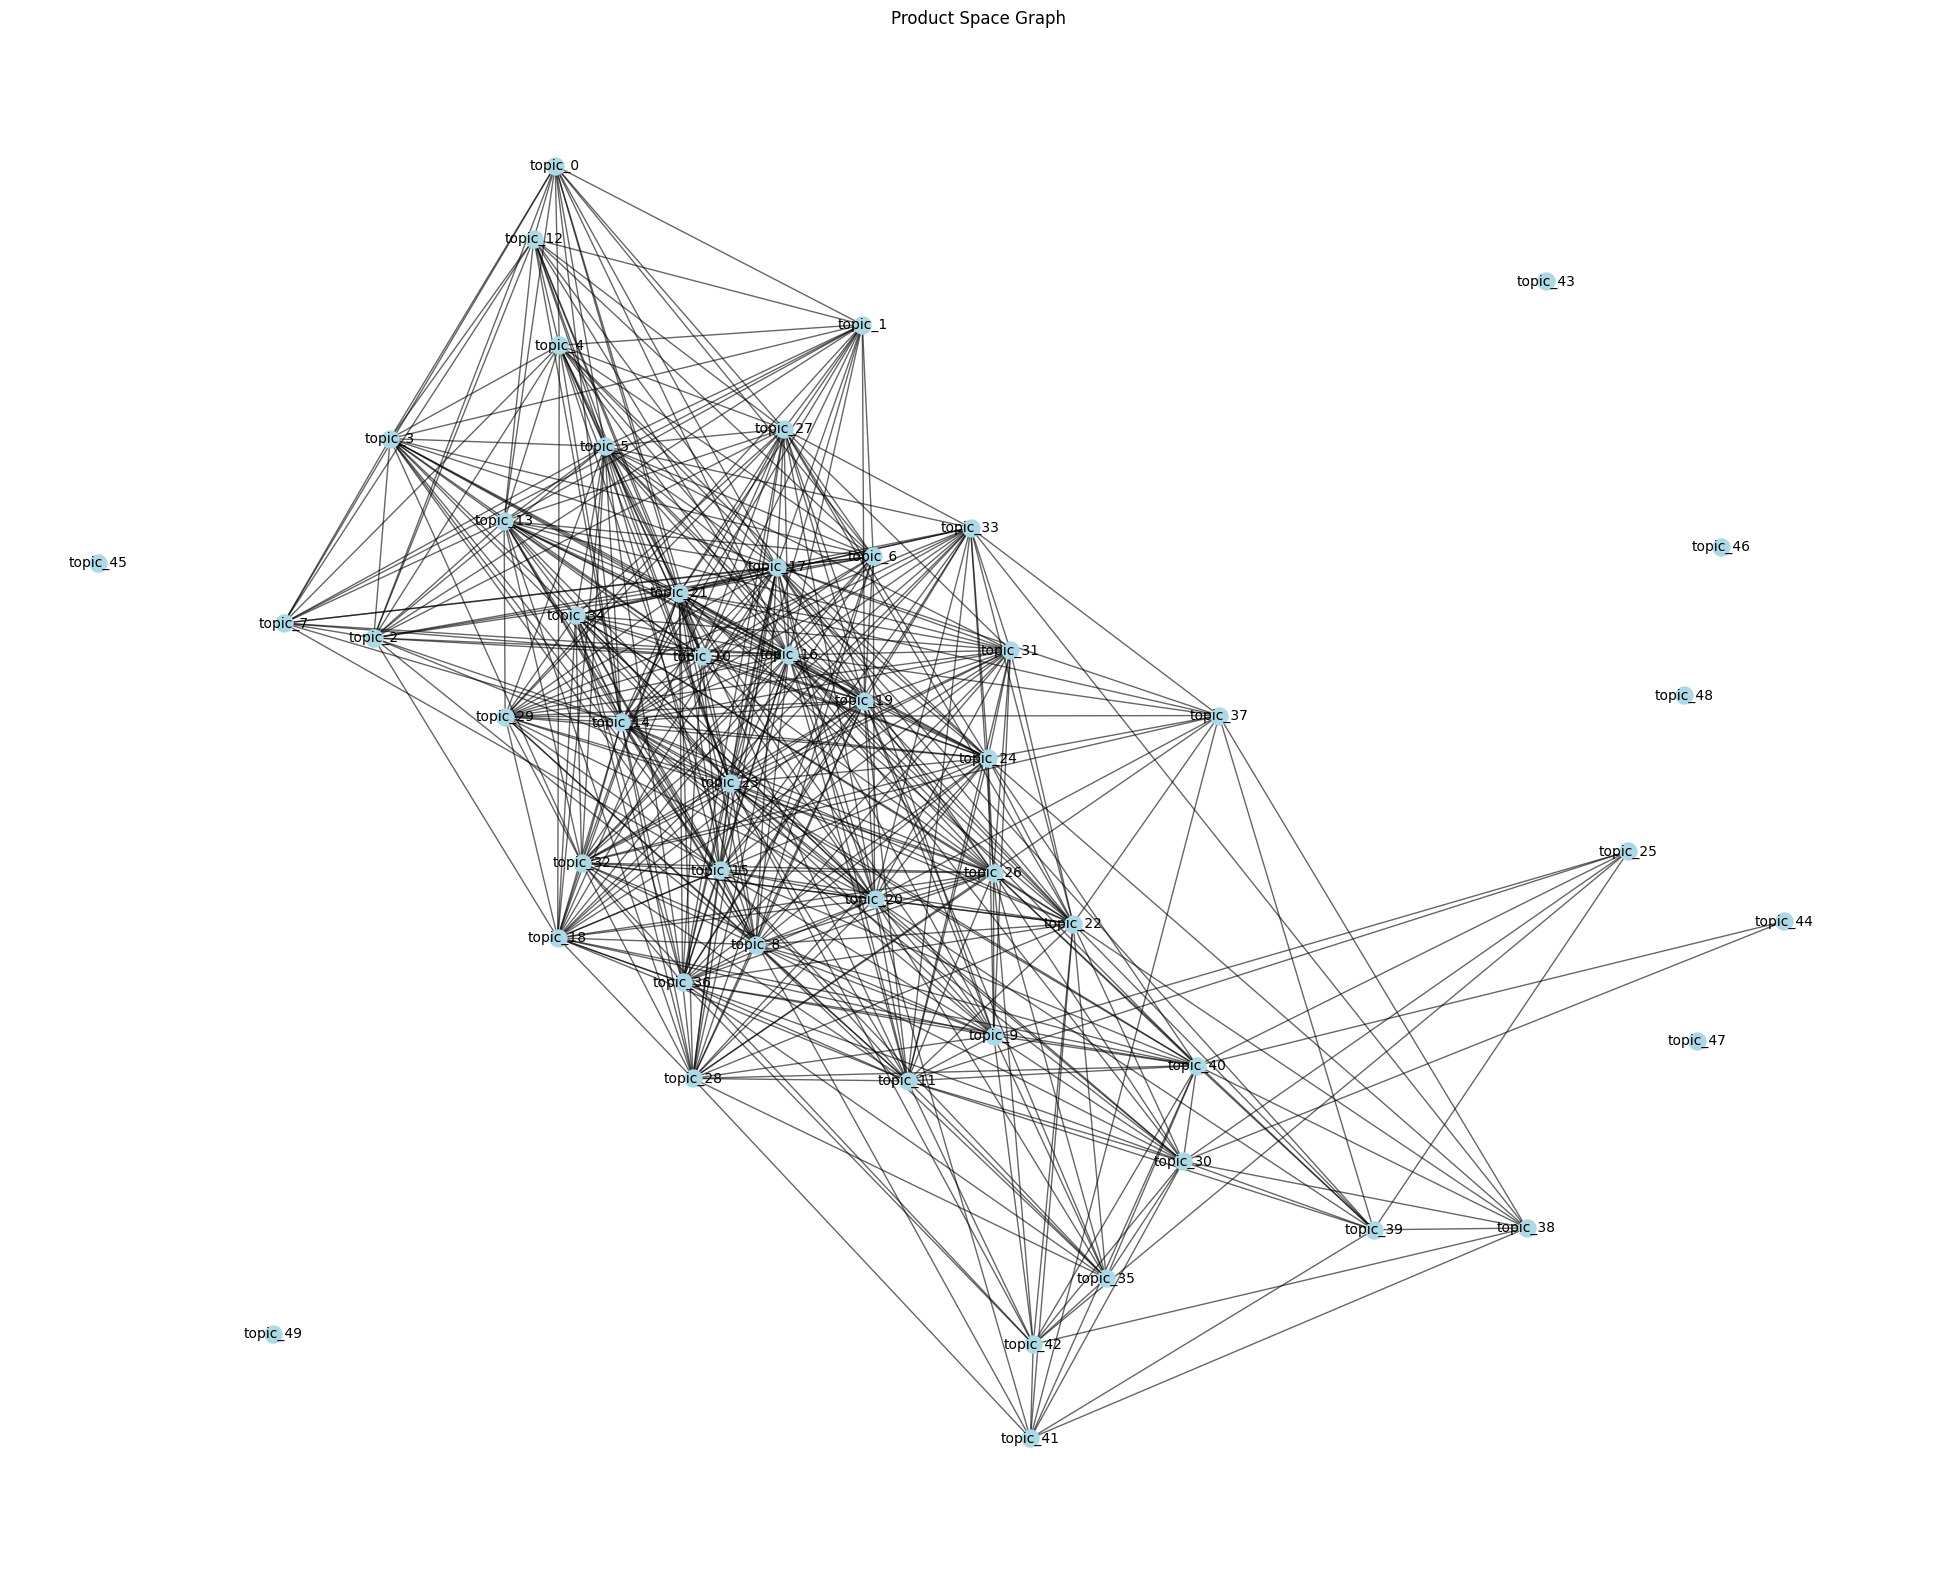

In [22]:
# Graph visualization
plt.figure(figsize=(25, 20))
pos = nx.spring_layout(G, k=1, scale=2, seed=42)  # Layout para la visualización
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=150)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.6)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10)
plt.title("Product Space Graph")
plt.axis('off')
plt.show()


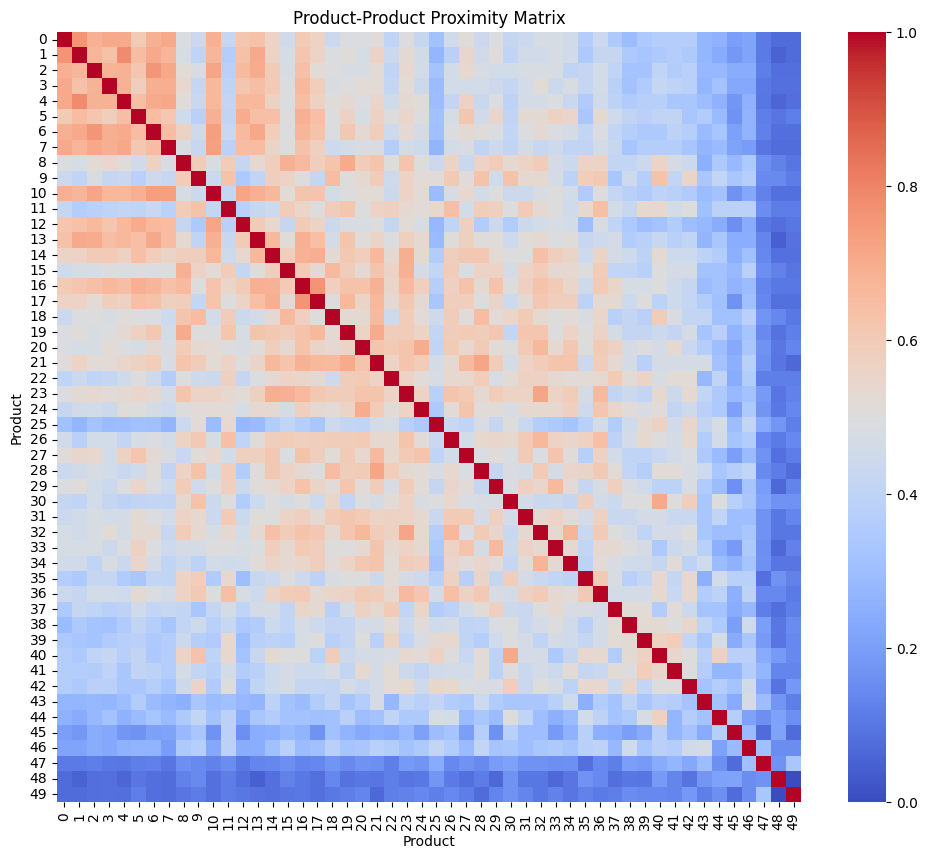

In [23]:
# HEATMAP
plt.figure(figsize=(12, 10))
ax = sns.heatmap(proximity_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Product-Product Proximity Matrix")
plt.xlabel("Product")
plt.ylabel("Product")
plt.show()


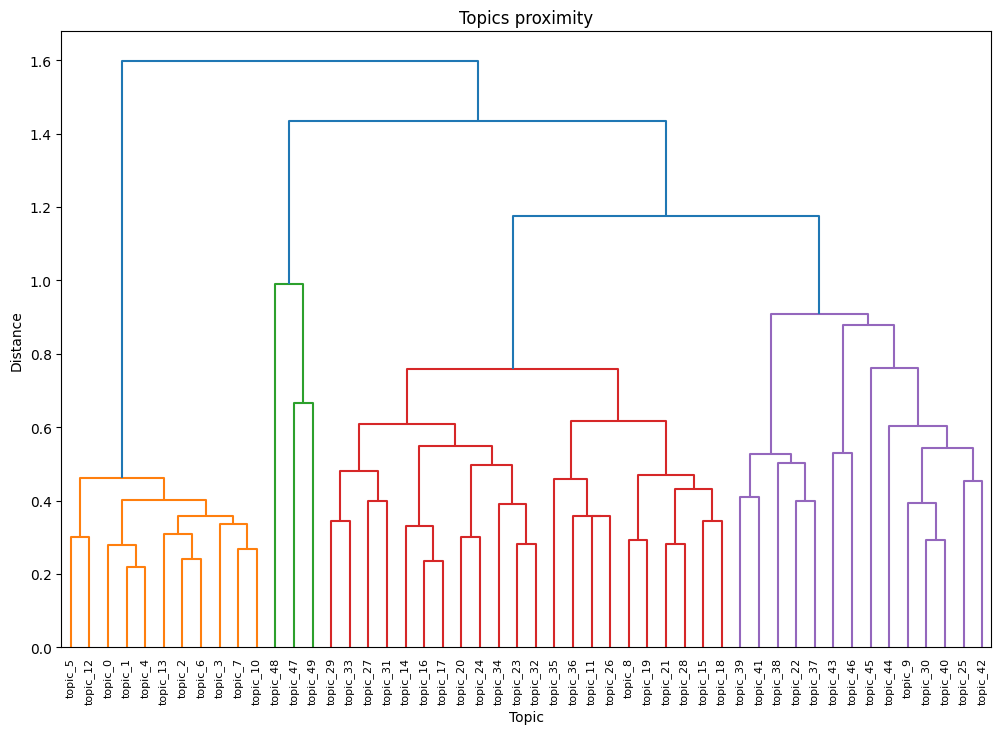

In [28]:
# Dendrograma
# Convertir la matriz de similitud en una matriz de distancia.
# Dado que la proximidad varía entre 0 y 1, podemos definir la distancia como: distancia = 1 - proximidad.
distance_matrix = 1 - proximity_matrix

# La función linkage requiere una matriz de distancias condensada.
condensed_distance = squareform(distance_matrix)

# Calcular el clustering jerárquico.
Z = linkage(condensed_distance, method='ward')

plt.figure(figsize=(12, 8))
# Suponiendo que los nombres de los productos están en df.columns:
dendrogram(Z, labels=list(topics))
plt.title("Topics proximity")
plt.xlabel("Topic")
plt.ylabel("Distance")
plt.show()


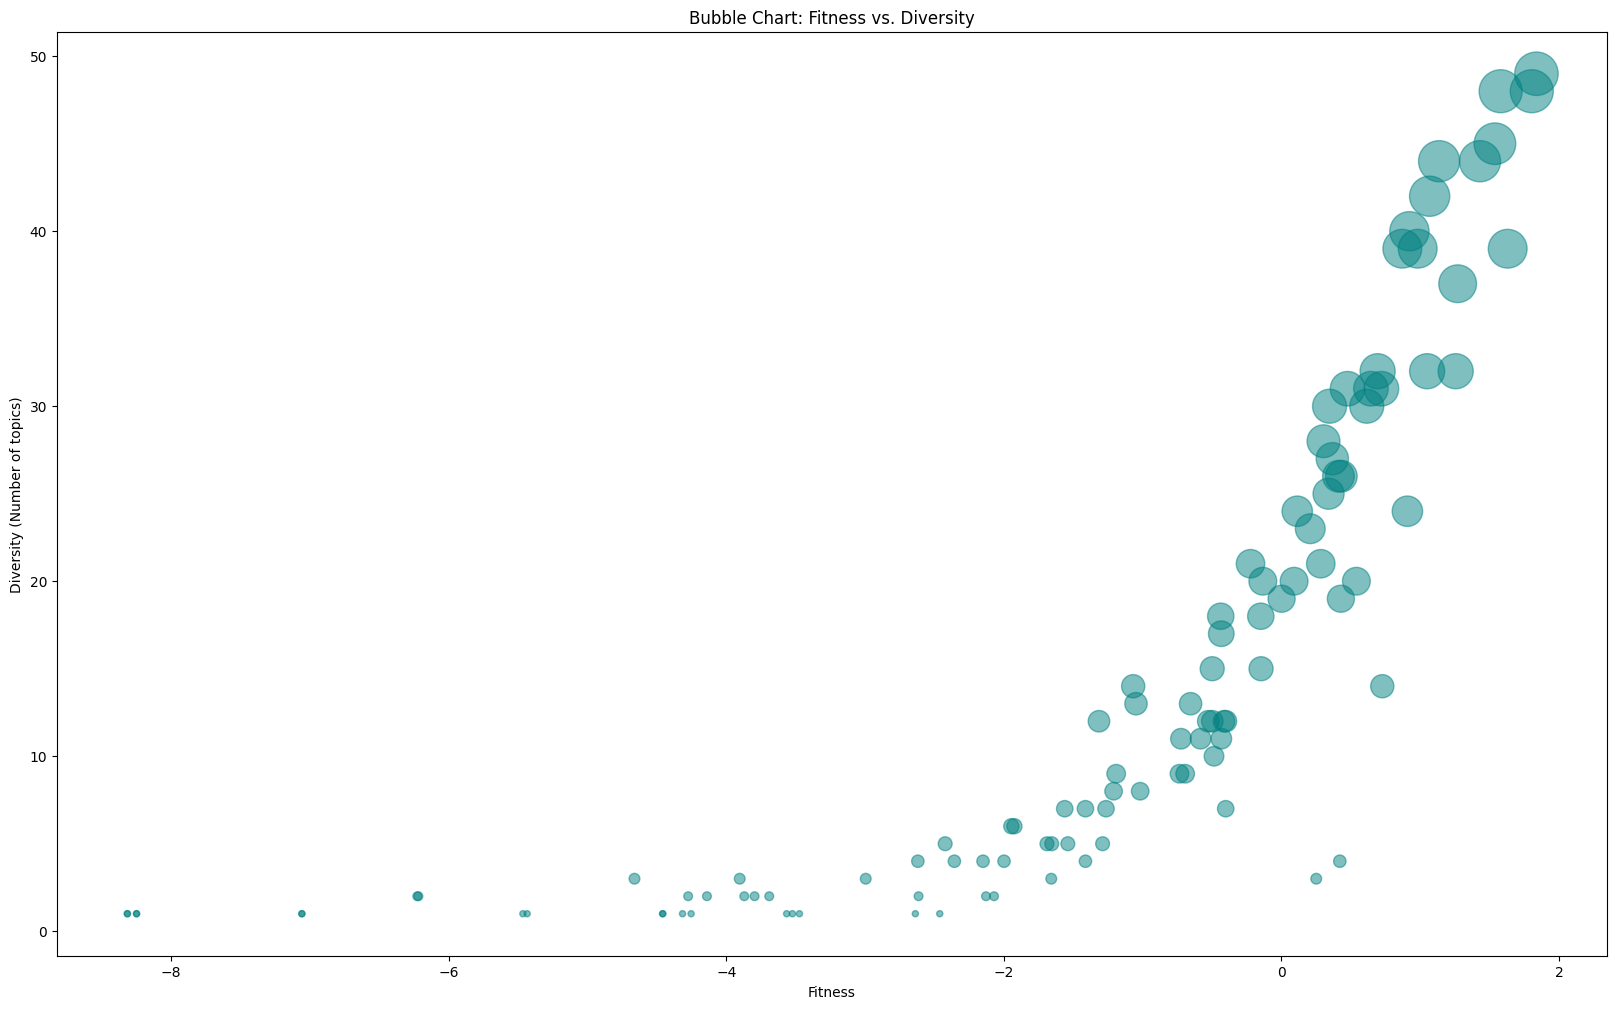

In [29]:
# Calcular la diversidad (número de productos exportados) para cada país.
# Suponiendo que 'df' contiene 0s y 1s, la suma a lo largo de las columnas da la diversidad.
df_fitness['logFitness'] = np.log(df_fitness['Fitness'] + 1e-220)

# Agregar la diversidad al DataFrame de fitness (suponiendo que 'df_fitness' ya fue creado previamente).
df_fitness = df_fitness.copy()  # En caso de que no lo hayas hecho ya
df_fitness['Diversity'] = diversity.values

plt.figure(figsize=(20, 12))
plt.scatter(df_fitness['logFitness'], df_fitness['Diversity'], 
            s=df_fitness['Diversity']*20,  # Escala el tamaño de la burbuja según la diversidad
            alpha=0.5, color='teal')
plt.xlabel('Fitness')
plt.ylabel('Diversity (Number of topics)')
plt.title('Bubble Chart: Fitness vs. Diversity')
plt.show()
